### Visualizing heatmaps of class activation

In [1]:
#loading the VGG16 model
from keras.applications.vgg16 import VGG16
model = VGG16(weights='imagenet')

Using TensorFlow backend.
W1105 09:50:03.523504  6676 deprecation_wrapper.py:119] From C:\Users\v-nitbal\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1105 09:50:03.800533  6676 deprecation_wrapper.py:119] From C:\Users\v-nitbal\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1105 09:50:03.968821  6676 deprecation_wrapper.py:119] From C:\Users\v-nitbal\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1105 09:50:04.225615  6676 deprecation_wrapper.py:119] From C:\Users\v-nitbal\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3976: The name tf.nn.max_poo

In [2]:
#preprocessing an input image for VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

img_path = r'C:\Users\v-nitbal\Documents\DL with Python - Francois Chollet\CNN for computer vision\african_elephants.jpg'

#load the image to the target size
img = image.load_img(img_path , target_size = (224,224))

#img to numpy array
x = image.img_to_array(img)

#add a dimension to transform the array into batch size of (1,224,224,3)
x = np.expand_dims(x, axis=0)

#preprocess the batch as in VGG16 (channel-wise normalization)
x = preprocess_input(x)
x.shape

(1, 224, 224, 3)

In [3]:
#preds contain the probability of all the 1000images predicted
preds = model.predict(x)
preds.shape

(1, 1000)

In [4]:
decode_predictions(preds,top=3)[0]

[('n02504458', 'African_elephant', 0.9094216),
 ('n01871265', 'tusker', 0.08618228),
 ('n02504013', 'Indian_elephant', 0.0043545854)]

In [5]:
#index of the max probability class
np.argmax(preds[0])

386

In [6]:
# Setting up the GRAD-CAM algorithm
african_elephant_output = model.output[:,386]
last_conv_layer = model.get_layer('block5_conv3')

In [7]:
#gradients of the "african elephant" class wrt output feature map of last conv layer
import keras.backend as K
grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]

#vector (512,) Global average pooling i.e average value of the gradient over each filter
pooled_grads = K.mean(grads, axis=(0,1,2))

iterate = K.function([model.input],[pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([x])
pooled_grads_value.shape

(512,)

In [14]:
#multiply each channel in the feature map array by "how important this channel is" wrt "elephant" class
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

#channel wise mean of the resulting feature map is the heatmap of the class activation
heatmap = np.mean(conv_layer_output_value, axis=-1)
heatmap.shape

(14, 14)

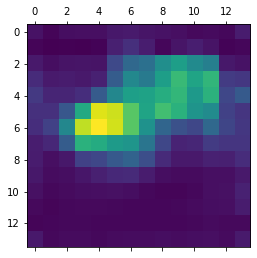

In [15]:
#heatmap post processing
import matplotlib.pyplot as plt
heatmap = np.maximum(heatmap,0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

In [12]:
#Super impose the heatmap with the original image
import cv2
img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img.shape[1],img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

superimposed_image = heatmap*0.4+img
cv2.imwrite(r'C:\Users\v-nitbal\Documents\DL with Python - Francois Chollet\CNN for computer vision\heatmap_african_elephants.jpg', superimposed_image)

True

In [10]:
conda install opencv

Solving environment: ...working... done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.
